In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/freddie-mac-loan-level/loan_level_500k.csv


In [2]:
import h2o
import matplotlib as plt
%matplotlib inline

#import estimators
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators import H2OXGBoostEstimator

#import h20 grid search
import h2o.grid
from h2o.grid.grid_search import H2OGridSearch


print('Setup Complete')

Setup Complete


In [3]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.7" 2020-04-14; OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-2ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-2ubuntu218.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp3p5_h307
  JVM stdout: /tmp/tmp3p5_h307/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp3p5_h307/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.5
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_unknownUser_o2kke2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [4]:
loan_level = h2o.import_file("https://s3.amazonaws.com/data.h2o.ai/DAI-Tutorials/loan_level_500k.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


# Regression Concepts

Regression Analysis/Regressor Model
Regression tries to predict a continuous number (as different from classification, which only categorizes). With a regressor model, you try to predict the exact number from your response column. In our case, we will try to predict the interest rate. You will see later on that some samples might have a 7.5% interest rate, and our regression model will try to predict that number.

There are different types of regression analysis; for example, there is a linear regression, where you fit a straight line to your response based on your predictors, and you try to predict your output with it. Linear regressions are only advised for datasets with a linear distribution. There are also non-linear regressions, which are more useful when you do not have a linear distribution of your response variable.

For regression use cases, H2O supports the following metrics:

R Squared (R2)
Mean Squared Error (MSE)
Root Mean Squared Error (RMSE)
Root Mean Squared Logarithmic Error (RMSLE)
Mean Absolute Error (MAE)
In this tutorial, we'll just focus on the RMSE and MAE.

MSE

The MSE metric measures the average of the squares of the errors or deviations. MSE takes the distances from the points to the regression line (these distances are the "errors") and squaring them to remove any negative signs. MSE incorporates both the variance and the bias of the predictor.
MSE also gives more weight to larger differences. The bigger the error, the more it is penalized. For example, if your correct answers are 2,3,4 and the algorithm guesses 1,4,3, then the absolute error on each one is exactly 1, so squared error is also 1, and the MSE is 1. But if the algorithm guesses 2,3,6, then the errors are 0,0,2, the squared errors are 0,0,4, and the MSE is a higher 1.333.

RMSE

The RMSE metric evaluates how well a model can predict a continuous value. The RMSE units are the same as the predicted target, which is useful for understanding if the size of the error is of concern or not. The smaller the RMSE, the better the model's performance. RMSE is sensitive to outliers, meaning that when the error is larger, the more it is penalized.

MAE

The MAE is an average of the absolute errors. The MAE units are the same as the predicted target as well as the RMSW, which is also useful for understanding whether the size of the error is of concern or not. The smaller the MAE, the better the model's performance. MAE is robust to outliers, meaning all errors are penalized equally.

For a detailed description of the other metrics, please check out the H2O-3 Documentation - Evaluation Model Metrics Section

Based-Tree Algorithms
Before we can talk about XGBoost, we first need to talk about Decision Trees and Trees Ensemble.

Decision Trees
Decision trees separate the data into a series of questions, and as the name suggests, it uses a tree-like model of decisions to make a prediction. Decision trees subdivide the dataset and move event outcomes left and right to build the tree model and fit all the data. The series of questions are generated automatically to optimize the separation of the data points depending on what you are trying to find whether you are doing a regression or classification tree.

Below is a simple example of a classification tree of looking through three different types of animals. We read the decision trees from top to bottom, and in this case, we can see that the first question is to decide whether the animal is a Fish or not. If the animal is not, then we see another question, which is Does the animal have feathers and depending on the answer to that question, then a decision is made. If the answer is Yes, then the decision tree says the animal is a Bird, but if the animal does not have feathers, then the decision tree says it is a Mammal. Please note that the tree could continue growing if we were trying to find a specific bird or mammal.

![https://h2oai.github.io/tutorials/introduction-to-machine-learning-with-h2o-part-2/img/dd522ba63e2f7f7c.jpg![image.png](attachment:image.png)]

decision-tree

Decisions trees have many strengths, such as being non-linear, this is very helpful because many times the datasets are not linear. They are robust to correlated features, meaning correlated features don't really affect their performance. They are also robust to missing values, so if you don't have some values, the trees are okay with that. Decision trees are also easy to understand, and also fast to train and score. However, they do have some weaknesses, and one of them is that when you do have a linear dataset, they are very inefficient when fitting a linear relationship. Also, they are not very accurate when compared to regularized linear models, or deep learning models, and one of the reasons for that is they tend to overfit. For that reason, we need to study tree ensembles, which is one of the solutions to the accuracy issue of decision trees.

Tree Ensembles
Trees Ensembles combine several decision trees in order to solve the same problem and make better predictions. One example of tree ensembles is Random Forest, which uses bagging or bootstrap aggregation, meaning we fit many different trees on different samples of the data. This is done by shuffling the data and growing a tree to obtain a result from it, then the data is shuffled one more time, and then we grow a new tree and combine the results of each of the trees to improve the overall performance. Another example is Gradient Boosting Machines (GBMs), which use boosting. In boosting, the trees are dependent on each other because GBMs fit consecutive trees, each tree solving the net error of the prior tree[1]. So, with GBMs, each tree is fixing up the net error of the entire system. Another example of tree ensembles is eXtreme Gradient Boosting or XGBoost

XGBoost
XGBoost is another decision-tree-based ensemble that uses boosting to yield accurate models. Similarly to the GBMs, XGBoost builds models sequentially, with each new model trying to solve the net error from the previous model. XGBoost provides parallel tree boosting (also known as GBDT, GBM) that solves many data science problems in a fast and accurate manner. For many problems, XGBoost is one of the best GBM frameworks today.

So why H2O's XGBoost?
H2O's XGboost is the same as the regular XGBoost, but using it under H2O, gives you the advantage to use all the features provided by H2O, such as the light data preparation. XGBoost only works with numbers; for that reason, H2O will automatically transform the data into a form that is useful for XGBoost, such as one-hot encode categorical features. H2O will also automatically choose sparse/dense data representation. Since XGBoost, as well as H2O, does in-memory computation, H2O takes advantage of that, and by formatting the data in an acceptable format for XGBoost, as well as doing some optimization, it achieves a fast in-memory computation. Other advantages of H2O's XGBoost is the ease to use, the ability to use H2O GridSearch to tune it, and also easy deployment. On top of that, you can also use Flow to explore your XGBoost model, and it is also one of the models included in H2O's AutoML. If you would like to know more about H2O XGBoost implementation, make sure to check out the Documentation section on XGBoost

Deep Learning
Deep learning is a subset of machine learning that uses neural networks to solve complex problems that other machine learning algorithms have difficulties with, such as image classification, speech recognition, etc. Deep Learning models have an advantage over standard machine learning because they are very effective at learning non-linear derived features from the input features. Neural networks are algorithms based on how the human brain works because they are composed of nodes or commonly known as "neurons," and thus the name of neural networks. One of the simplest neural network architecture is a single layer perceptron. A perceptron takes binary inputs, as shown in the picture below, and produces a single binary output[2].

https://h2oai.github.io/tutorials/introduction-to-machine-learning-with-h2o-part-2/img/a77132f53de71ac7.jpg![image.png](attachment:image.png)

perceptron

In the figure above, we see a perceptron with three inputs; these inputs are fed into the neuron, which will then decide if the output should be a zero or one. Simply said, a neuron is a function that takes multiple numeric inputs and yields a numeric output. Below is a representation of a more complex neural network

deep-neural-network


In the image above, you can see a neural network with two hidden layers, and with an input and output layer. We can say that the input layer has six neurons, the first hidden layer has four neurons, while the second hidden layer has 3, and lastly, the output layer has one neuron. A neural network can have as many hidden layers as the user may find suitable.
Although deep learning models can solve almost any problem, they tend to be slow and can be hard to use and tune. Nowadays, none of the most popular deep learning frameworks is TensorFlow, as it is an open-source AI library that allows users to create different types of neural networks with many layers. Tensorflow allows you to build Deep Neural Networks(DNNs), which are feedforward multilayer neural networks, among other types of models. TensorFlow also provides DNNs models for classification and for regression use cases as different models.

So why H2O's Deep Learning?
H2O's implementation of Deep Learning is based on a multi-layer feedforward artificial neural network that is trained with stochastic gradient descent using back-propagation. The network can contain a large number of hidden layers consisting of neurons with tanh, rectifier, and maxout activation functions. Advanced features such as adaptive learning rate, rate annealing, momentum training, dropout, L1 or L2 regularization, checkpointing, and grid search enable high predictive accuracy. Although DNNs can be very good at finding different patterns on data, they are not very helpful for image classification.
One advantage of H2O implementations is that it is designed to run in parallel across a cluster on very large data. This makes H2O implementation faster than other libraries performing a similar task. Another advantage is that it is fairly easy to use, as the model is instantiated in the same manner as the other H2O estimators. On top of that, you also get the ability to use all the features from H2O with your DNN model. For more information about H2O Deep Learning, make sure you check out the Documentation Section on Deep Learning



In [5]:
loan_level.head()

CREDIT_SCORE,FIRST_PAYMENT_DATE,FIRST_TIME_HOMEBUYER_FLAG,MATURITY_DATE,METROPOLITAN_STATISTICAL_AREA,MORTGAGE_INSURANCE_PERCENTAGE,NUMBER_OF_UNITS,OCCUPANCY_STATUS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,ORIGINAL_UPB,ORIGINAL_LOAN_TO_VALUE,ORIGINAL_INTEREST_RATE,CHANNEL,PREPAYMENT_PENALTY_MORTGAGE_FLAG,PRODUCT_TYPE,PROPERTY_STATE,PROPERTY_TYPE,POSTAL_CODE,LOAN_SEQUENCE_NUMBER,LOAN_PURPOSE,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS,SELLER_NAME,SERVICER_NAME,PREPAID,DELINQUENT
669,200206,N,202901,nan,0,1,O,80,33,162000,80,7.12,R,N,FRM,WV,SF,26100,F199Q1000004,P,320,2,Other sellers,Other servicers,TRUE,FALSE
732,199904,N,202903,17140,0,1,O,25,10,53000,25,6.5,R,N,FRM,OH,SF,45200,F199Q1000005,N,360,1,Other sellers,Other servicers,TRUE,FALSE
679,200208,N,202902,15940,30,1,O,91,48,133000,91,6.75,R,N,FRM,OH,SF,44700,F199Q1000007,P,319,1,Other sellers,Other servicers,TRUE,FALSE
721,200209,N,202902,38060,0,1,O,39,13,174000,39,6.625,T,N,FRM,AZ,SF,85200,F199Q1000013,N,318,2,Other sellers,Other servicers,TRUE,FALSE
618,200210,N,202902,10420,25,1,O,85,24,122000,85,6.375,R,N,FRM,OH,SF,44200,F199Q1000015,N,317,2,Other sellers,Other servicers,TRUE,FALSE
738,200211,N,202903,10420,0,1,O,73,44,218000,73,6,R,N,FRM,OH,SF,44300,F199Q1000016,P,317,2,Other sellers,Other servicers,TRUE,FALSE
761,200211,N,202904,nan,0,1,O,73,31,138000,73,6.375,R,N,FRM,SC,PU,29500,F199Q1000017,P,318,2,Other sellers,Other servicers,TRUE,FALSE
707,200211,N,202903,33340,0,1,O,60,57,136000,60,6.25,R,N,FRM,WI,SF,53000,F199Q1000018,C,317,2,Other sellers,Other servicers,TRUE,FALSE
760,200211,N,202903,33340,0,1,O,63,30,79000,63,6.125,R,N,FRM,WI,SF,53000,F199Q1000019,N,317,2,Other sellers,Other servicers,TRUE,FALSE
691,200302,N,202901,15940,0,1,O,65,25,130000,65,5.875,R,N,FRM,OH,SF,44700,F199Q1000023,P,312,2,Other sellers,Other servicers,TRUE,FALSE


In [6]:
loan_level['ORIGINAL_INTEREST_RATE'].describe()

Rows:500137
Cols:1




,ORIGINAL_INTEREST_RATE
type,real
mins,4.625
mean,7.18268686379932
maxs,11.5
sigma,0.5799408623980612
zeros,0
missing,0
0,7.12
1,6.5
2,6.75


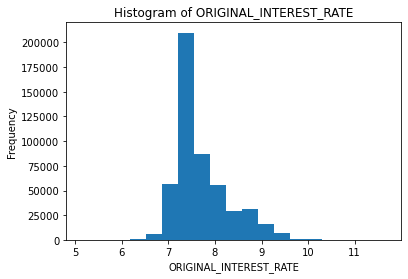

In [7]:
loan_level['ORIGINAL_INTEREST_RATE'].hist()

We will split the dataset into three sets, training, validation, and test set. The reason for having validation and test sets is because we will use the validation set to tune our models, and we will treat the test set as some unseen data in which we will see how our models perform. We will assign 70% of our data to the training set, and 15% to both the validation and test sets.
Split the dataset and print the distribution of each set

In [8]:
train, valid, test = loan_level.split_frame([0.70, 0.15], seed=42)
print('train:%d valid:%d test:%d' % (train.nrows, valid.nrows, test.nrows))

train:350268 valid:74971 test:74898


Choose your y variable (target), and your x variable (predictors/features)

In [9]:
y = 'ORIGINAL_INTEREST_RATE'

ignore =  ['ORIGINAL_INTEREST_RATE',
       'FIRST_PAYMENT_DATE',
       'MATURITY_DATE',
       'MORTGAGE_INSURANCE_PERCENTAGE',
       'PREPAYMENT_PENALTY_MORTGAGE_FLAG',
       'LOAN_SEQUENCE_NUMBER',
       'PREPAID',
       'DELINQUENT',
       'PRODUCT_TYPE']
x = list(set(train.names) - set(ignore))

The reason we are ignoring all those columns is that at the time someone would have to decide the interest rate for a loan, they will not have access to that information. For that reason, it would not make sense to train the model with data that will not be available when trying to make predictions. Now we are ready to build our first regression model.

## Build XGBoost Model

To use the XGBoost estimator, in this tutorial we can just define a random seed (for reproducibility purposes) and the model ID, in case we wanted to save the model and then retrieve it, or to easily access it in Flow. As we mentioned before, we will be tuning our models with the validation set; however, we could also get a validation score using k-fold cross validation from H2O. We will show you how you would use the k-fold cross-validation, but we are going to use the validation set approach because when training the models, and doing the grid search, it will be much faster than using the k-fold cross-validation approach.

To build your default XGBoost model and to train it, just run the following two lines of code:

In [10]:
xgb = H2OXGBoostEstimator(seed=42, model_id='XGBoost', nfolds=0, keep_cross_validation_predictions = False,)

%time xgb.train(x=x, y=y, training_frame=train, validation_frame=valid)

xgboost Model Build progress: |███████████████████████████████████████████| 100%
CPU times: user 366 ms, sys: 38.6 ms, total: 405 ms
Wall time: 21.9 s


Note: You do not need to specify the cross-validation parameters, but we want to show the parameters that you would have to change in order to enable H2O internal cross-validation. If you wanted to use the H2O cross-validation, you would have to set keep_cross_validation_predictions to True and change nfolds to 3, 5, or 10, depending on the number of folds that you want; by doing cross-validation, you no longer need a validation frame.

After the XGBoost model is done training, you can print the model summary just by typing the name of your model in a new cell and running it as shown below:

In [11]:
xgb

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.17744636323085577
RMSE: 0.42124382871545524
MAE: 0.30712844420662655
RMSLE: 0.04987056256391181
Mean Residual Deviance: 0.17744636323085577

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 0.18013989282125545
RMSE: 0.42442890196269084
MAE: 0.3108204587914598
RMSLE: 0.05030529823382512
Mean Residual Deviance: 0.18013989282125545

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2020-06-29 18:07:17,0.056 sec,0.0,6.708863,6.683679,45.008844,6.704750,6.679805,44.953673
1,,2020-06-29 18:07:19,2.597 sec,1.0,4.710473,4.678698,22.188559,4.707354,4.675791,22.159185
2,,2020-06-29 18:07:20,3.259 sec,2.0,3.316827,3.275220,11.001343,3.313931,3.272599,10.982141
3,,2020-06-29 18:07:20,3.833 sec,3.0,2.348813,2.292739,5.516923,2.346267,2.290480,5.504970
4,,2020-06-29 18:07:21,4.331 sec,4.0,1.681035,1.605171,2.825880,1.678602,1.603109,2.817706
5,,2020-06-29 18:07:21,4.886 sec,5.0,1.226532,1.124544,1.504380,1.224442,1.122776,1.499259
6,,2020-06-29 18:07:22,5.433 sec,6.0,0.924077,0.792144,0.853918,0.921823,0.790251,0.849757
7,,2020-06-29 18:07:26,9.477 sec,18.0,0.445831,0.326121,0.198765,0.445885,0.327571,0.198814
8,,2020-06-29 18:07:30,13.738 sec,30.0,0.433406,0.316909,0.187840,0.434432,0.319212,0.188731
9,,2020-06-29 18:07:34,17.902 sec,43.0,0.425616,0.310474,0.181149,0.427974,0.313689,0.183162



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,"SELLER_NAME.NORWESTMORTGAGE,INC",25657.996094,1.000000,0.239125
1,OCCUPANCY_STATUS.I,7086.139160,0.276177,0.066041
2,ORIGINAL_UPB,6440.511230,0.251014,0.060024
3,ORIGINAL_LOAN_TO_VALUE,5813.790527,0.226588,0.054183
4,LOAN_PURPOSE.P,4025.863281,0.156905,0.037520
5,CREDIT_SCORE,3827.816650,0.149186,0.035674
6,"SERVICER_NAME.ABNAMROMTGEGROUP,INC",3514.124512,0.136960,0.032751
7,SELLER_NAME.COUNTRYWIDE,3313.306641,0.129133,0.030879
8,SELLER_NAME.NATLCITYMTGECO,3025.856445,0.117930,0.028200
9,SELLER_NAME.CROSSLANDMTGECORP,2976.497314,0.116007,0.027740



See the whole table with table.as_data_frame()


When printing the model summary, you will see a complete summary with some of the parameters in your model (in this case, we only see the number of trees). You will see some scoring metrics on your training data, as well as on your validation data, as shown in the image above. From the report, we can see that the MAE, in fact, is lower than the RMSE, this might be due to having some of the interest rates at the far end of our range (such as interest rates as high as 10 and 11, when our mean is 7.2). The training and validation RMSE are 0.4212 and 0.4244, respectively. This means that according to the RMSE, on average, the predictions are 0.42 percent off from the actual values. While the training and validation MAE are 0.3071 and 0.3108 respectively, which tells us that the predictions are about 0.31 percent off from the actual values, according to the MAE. Since we have a target interest rate range between 4 to 12 percent, we will try to reduce the RMSE when tuning our models as it will penalize larger errors or outliers.

In the model summary, you will also see two tables; the first table is the scoring history, and the second one is the variable importance table (not shown here). Besides looking at the table, we can also take a look at both graphing representations of the scoring history and the variable importance.

Let's first plot the scoring history.

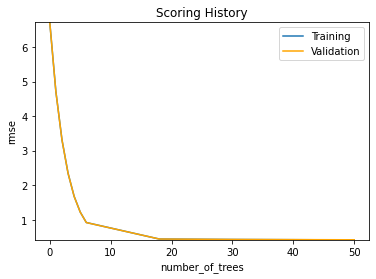

In [12]:
xgb.plot()

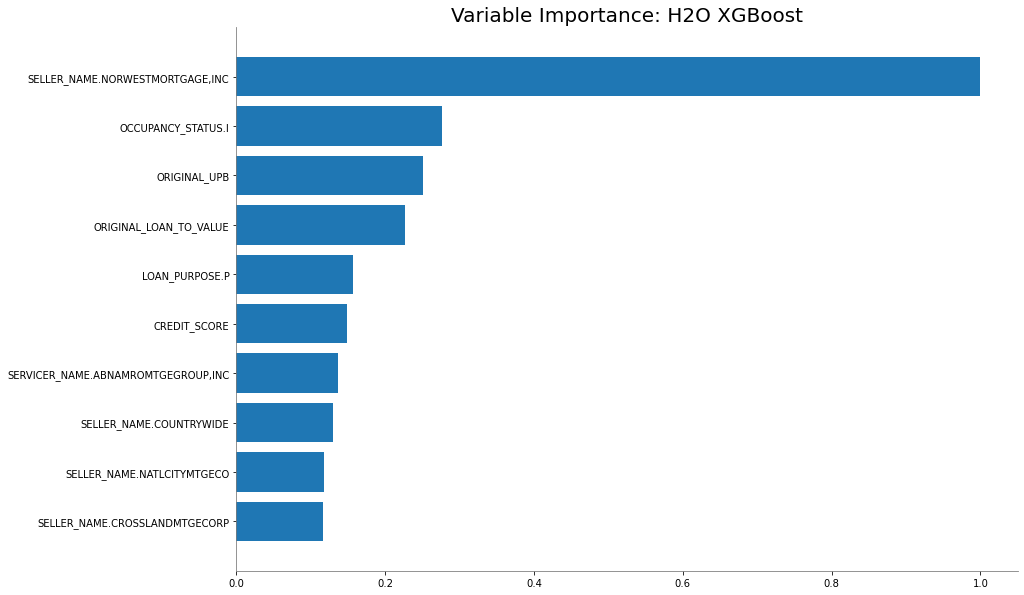

In [13]:
xgb.varimp_plot()

We will make some predictions on our validation set. To compare the predictions to the actual value, we are going to bind the two data frames, the predictions and the validation set, as follow:

In [14]:
xgb_def_pred = xgb.predict(valid)
xgb_def_pred.cbind(valid['ORIGINAL_INTEREST_RATE'])

xgboost prediction progress: |████████████████████████████████████████████| 100%


predict,ORIGINAL_INTEREST_RATE
7.20097,5.875
6.87724,6.75
7.0235,7.75
7.25526,6.625
7.02648,6.75
7.38137,7
6.8168,7
7.40214,7
7.06643,7.25
7.00728,7


In the first ten predictions, we can see that they are somewhat close to the actual value, except for the first sample, which is more than 1.5% off. We can see that samples such as this one, might make the RMSE higher than the MAE.

We can also check the model performance with a test, or in this case, with a validation set, and print some of the scores for our model. For now, we will just save the model performance, as we will use later on.



In [15]:
default_xgb_per = xgb.model_performance(valid)

# Build a Deep Learning Model

As mentioned before, the deep learning estimator is fairly easy to use. For our default Deep Learning model, we do not need to define any parameters, but we will define the seed, model id, and we will also make sure that cross-validation is disabled, as we are using a validation frame.

In [16]:
dl = H2ODeepLearningEstimator(seed=42, model_id='DL',
                             nfolds=0,
                             keep_cross_validation_predictions=False
                             )

%time dl.train(x=x,y=y, training_frame=train, validation_frame=valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
CPU times: user 1.37 s, sys: 118 ms, total: 1.49 s
Wall time: 3min 50s


In [17]:
dl

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DL


Status of Neuron Layers: predicting ORIGINAL_INTEREST_RATE, regression, gaussian distribution, Quadratic loss, 73,601 weights/biases, 880.4 KB, 3,506,365 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,165,Input,0,,,,,,,,,
1,,2,200,Rectifier,0,0,0,0.0550759,0.213325,0,-0.0138589,0.192122,-0.0481878,0.289429
2,,3,200,Rectifier,0,0,0,0.0623866,0.0578115,0,-0.0506772,0.138439,0.092284,0.466823
3,,4,1,Linear,,0,0,0.00127749,0.000878607,0,-0.00265171,0.0887763,0.72561,1.09713e-154




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.18197789635665312
RMSE: 0.42658867349784746
MAE: 0.30070144083106415
RMSLE: 0.05048457295957043
Mean Residual Deviance: 0.18197789635665312

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 0.1878541750858087
RMSE: 0.4334214751091698
MAE: 0.3065182099025638
RMSLE: 0.05127850810428358
Mean Residual Deviance: 0.1878541750858087

Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2020-06-29 18:07:40,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2020-06-29 18:07:45,8.516 sec,3604 obs/sec,0.053842,1,18859.0,0.548064,0.300374,0.377567,0.085729,0.551400,0.304042,0.378840,0.089378
2,,2020-06-29 18:08:16,38.601 sec,10975 obs/sec,1.028741,19,360335.0,0.452519,0.204773,0.315438,0.376717,0.454908,0.206941,0.317815,0.380201
3,,2020-06-29 18:08:41,1 min 4.128 sec,12912 obs/sec,2.055206,38,719873.0,0.535231,0.286473,0.423619,0.128042,0.533410,0.284527,0.422800,0.147829
4,,2020-06-29 18:09:08,1 min 31.127 sec,14214 obs/sec,3.246286,60,1137070.0,0.472456,0.223214,0.349918,0.320587,0.471360,0.222180,0.349911,0.334560
5,,2020-06-29 18:09:36,1 min 58.842 sec,15160 obs/sec,4.547481,84,1592837.0,0.480995,0.231356,0.351841,0.295805,0.479952,0.230354,0.352016,0.310079
6,,2020-06-29 18:10:03,2 min 26.203 sec,15820 obs/sec,5.847779,108,2048290.0,0.462892,0.214269,0.316855,0.347814,0.471521,0.222332,0.321986,0.334104
7,,2020-06-29 18:10:33,2 min 55.773 sec,16483 obs/sec,7.362114,136,2578713.0,0.456823,0.208687,0.313442,0.364804,0.465445,0.216639,0.318404,0.351156
8,,2020-06-29 18:10:59,3 min 22.448 sec,16948 obs/sec,8.713071,161,3051910.0,0.434112,0.188453,0.302616,0.426392,0.443386,0.196591,0.308649,0.411201
9,,2020-06-29 18:11:28,3 min 50.474 sec,17047 obs/sec,10.010521,185,3506365.0,0.426589,0.181978,0.300701,0.446101,0.433421,0.187854,0.306518,0.437367



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,SELLER_NAME.Other sellers,1.000000,1.000000,0.012072
1,SELLER_NAME.WELLSFARGOHOMEMORTGA,0.971140,0.971140,0.011723
2,"SELLER_NAME.NORWESTMORTGAGE,INC",0.938348,0.938348,0.011328
3,"SELLER_NAME.ABNAMROMTGEGROUP,INC",0.920032,0.920032,0.011107
4,OCCUPANCY_STATUS.O,0.871191,0.871191,0.010517
5,SELLER_NAME.STANDARD FEDERAL BAN,0.866704,0.866704,0.010463
6,SELLER_NAME.CROSSLANDMTGECORP,0.855815,0.855815,0.010331
7,SELLER_NAME.CHASEMANHATTANMTGECO,0.844506,0.844506,0.010195
8,"SELLER_NAME.NORWEST MORTGAGE, IN",0.828709,0.828709,0.010004
9,SELLER_NAME.FIRST UNION CAPITAL,0.808627,0.808627,0.009762



See the whole table with table.as_data_frame()


For our deep learning model, we see that our validation scores are higher than the training scores, but not by much. The training and validation RMSE are 0.4395 and 0.4480, respectively. And the training and validation MAE are 0.3240 and 0.3298, respectively. You can also see the scoring history and variable importance table. You can plot both the scoring history and variable importance plot.

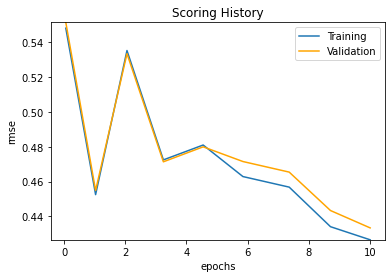

In [18]:
dl.plot()

In [19]:
print('epochs = ', dl.params['epochs'])

epochs =  {'default': 10.0, 'actual': 10.0}


The default number of epochs for a Deep Learning model is 10. We will try to find a number of epochs that will give us a better score when we tune our model.

Let's take a quick look at the variable importance plot to see how it compares to the variable importance plot from our XGBoost model.

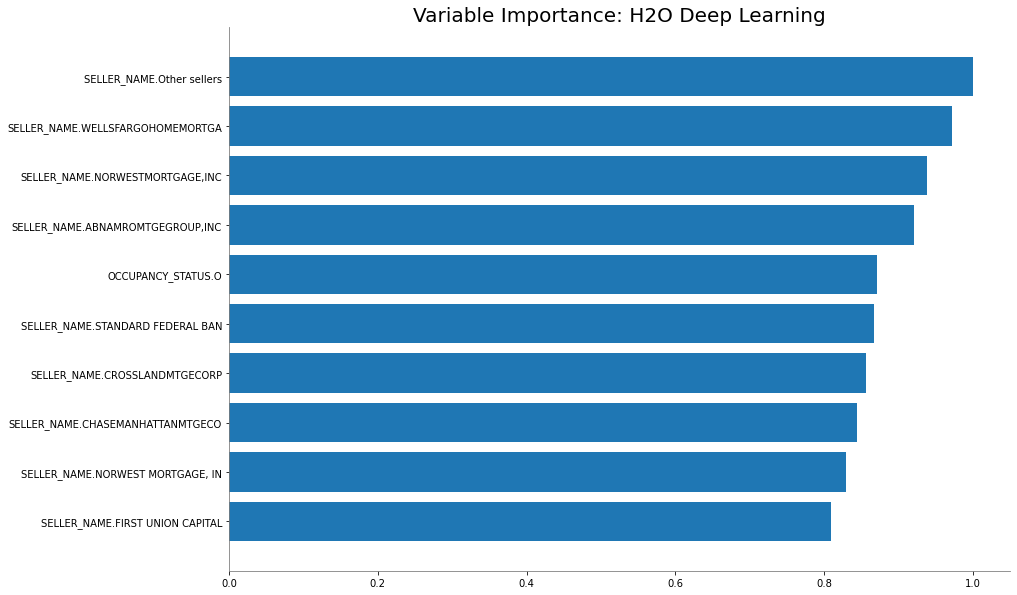

In [20]:
dl.varimp_plot()

As we can see in the image above, the variable importance plot changes a lot compared to the XGBoost. For our Deep Learning model, we see most of the SELLER_NAME variables, and the most important variable for our Deep Learning model "Other sellers" is not even included in the top ten for the XGBoost. Also, the top 10 most important variables for the Deep Learning model have almost the same significance, as opposed to the other model.

Save the model performance on the validation set, as we will use it later on for comparison purposes.

In [21]:
default_dl_per = dl.model_performance(valid)

# Tune XGBoost Model with H2O GridSearch

We will first try to find the max_depth for our XGBoost, as this is one of the most important parameters for an XGBoost model.

max_depth defines the number of nodes along the longest path from the start of the tree to the farthest leaf node. By default, the value is 6. We could do a random search along with the other parameters, but when max_depth is large, the model takes longer to train; therefore, in order to do a more efficient random search with the other parameters, we will first find the best value max_depth, and we will use 100 trees with early stopping to tune our hyper-parameters.

In [22]:
xgb = H2OXGBoostEstimator(model_id = 'xgb',
                          ntrees = 100,
                          stopping_rounds = 5, #default
                          stopping_tolerance = 1e-4, #default
                          stopping_metric = 'rmse', #default
                          seed = 42
                          )

hyper_params = {'max_depth': [5,7,9,10,12,13,15,20]
               }

grid_id = 'depth_grid'

search_criteria = {'strategy': 'Cartesian'}

xgb_grid = H2OGridSearch(model = xgb,
                        hyper_params = hyper_params,
                        grid_id = grid_id,
                        search_criteria = search_criteria
                        )

%time xgb_grid.train(x=x, y=y, training_frame=train, validation_frame=valid)

xgboost Grid Build progress: |████████████████████████████████████████████| 100%
CPU times: user 2.86 s, sys: 252 ms, total: 3.11 s
Wall time: 11min 55s


We can get the models trained by the GridSearch with the .get_grid() function, and print it in a nice table format with .sorted_metric_table() function.

In [23]:
sorted_xgb = xgb_grid.get_grid(sort_by = 'rmse', decreasing = False)
sorted_xgb.sorted_metric_table()

,,max_depth,model_ids,rmse
0,,9,depth_grid_model_3,0.4134845920019427
1,,10,depth_grid_model_4,0.4137581436204251
2,,7,depth_grid_model_2,0.41471101533590643
3,,12,depth_grid_model_5,0.41641601585589505
4,,13,depth_grid_model_6,0.4203949347712376
5,,5,depth_grid_model_1,0.42045683416828616
6,,15,depth_grid_model_7,0.4248075493909256
7,,20,depth_grid_model_8,0.4379012818657789


We will use max_depth equal to 9 to try to tune the next parameters. We will keep the same number of trees, at ntrees=100. We will start by searching over five parameters, and see if we get any improvement. Here is the list of the five parameters that we will tune.

1. reg_alpha: Specify a value for L1 regularization. L1 regularization encourages sparsity, meaning it will make the weights at the leaves become 0. This value defaults to 0.

2. reg_lambda: Specify a value for L2 regularization. L2 Regularization makes some of the weights at the leaves to be small, but not zero. This defaults to 1.

3. learn_rate (alias: eta): Specify the learning rate by which to shrink the feature weights. Shrinking feature weights after each boosting step makes the boosting process more conservative and prevents overfitting. The range is 0.0 to 1.0. This value defaults to 0.3.

4. distribution: Specify the distribution (i.e., the loss function). The options are AUTO, Bernoulli, multinomial, gaussian, poisson, gamma, or tweedie. Since our response is numeric, we will just include poisson, Tweedie, Gaussian, and gamma.

5. booster: Specify the booster type. This can be one of the following: "gbtree," "gblinear," or "dart." Note that "gbtree" and "dart" use a tree-based model while "gblinear" uses a linear function. This value defaults to "gbtree."

Since we have several parameters, we will be doing a random search; we will be using early stopping, and for our stopping criteria, we will set a limit of 100 models or 15 minutes. You can change these settings in the "search_criteria_tune" parameter for the grid search.



In [24]:
xgb = H2OXGBoostEstimator(model_id = 'xgb_grid',
                         max_depth = 9,
                         ntrees = 100,
                         stopping_rounds = 5, #default
                         stopping_tolerance = 1e-4, #default
                         stopping_metric = 'rmse', #default
                         seed = 42
                         )

hyper_params = {'reg_alpha': [x*0.01 for x in range(0,101)],
               'reg_lambda': [x*0.01 for x in range(0,101)],
               'learn_rate': [x*0.01 for x in range(1,101)],
               'distribution': ['poisson', 'tweedie', 'gaussian', 'gamma'],
               'booster': ['gbtree', 'gblinear', 'dart']
               }

search_criteria_tune = {'strategy': 'RandomDiscrete',
                       'max_runtime_secs': 900, #15mins
                       'max_models': 100,  # build no more than 100 models
                       'seed': 42
                       }

xgb_grid = H2OGridSearch(xgb,
                        hyper_params,
                        grid_id = 'random_grid',
                        search_criteria = search_criteria_tune,
                        )

%time xgb_grid.train(x=x, y=y, training_frame=train, validation_frame=valid)

xgboost Grid Build progress: |████████████████████████████████████████████| 100%
CPU times: user 4.39 s, sys: 376 ms, total: 4.76 s
Wall time: 15min 1s


In [25]:
sorted_xgb = xgb_grid.get_grid(sort_by = 'rmse',decreasing=False)
sorted_xgb.sorted_metric_table()

,,booster,distribution,learn_rate,reg_alpha,reg_lambda,model_ids,rmse
0,,gbtree,gaussian,0.28,0.8,0.35,random_grid_model_10,0.4125599319230789
1,,gbtree,tweedie,0.26,0.29,0.51,random_grid_model_5,0.41279918608319316
2,,dart,gamma,0.72,0.52,0.44,random_grid_model_4,0.4218293474547786
3,,dart,gamma,0.76,0.62,0.96,random_grid_model_8,0.4227470966107354
4,,dart,gamma,0.99,0.99,0.68,random_grid_model_6,0.4277780874565331
5,,dart,tweedie,0.75,0.95,0.63,random_grid_model_3,0.4280075941717503
6,,gbtree,tweedie,0.8300000000000001,0.79,0.51,random_grid_model_7,0.4320765896187033
7,,gbtree,gaussian,0.96,0.96,0.81,random_grid_model_2,0.4488525812078407
8,,dart,poisson,0.92,0.81,0.74,random_grid_model_1,0.45427138152832197
9,,dart,gamma,0.14,0.17,0.12,random_grid_model_11,0.4946346915179043


With the grid search that we just did allowed us to train a total of 41 models (not all the models are shown). As you can see, the top model has a gbtree booster with a gaussian distribution, and the second-best model also has a gbtree booster with a tweedie distribution. We can also see that the next two models with the dart booster yield good scores. Since the dart booster configuration yields good results, we will try to tune some extra parameters for the third model, which uses the dart booster. Dart booster is a "method to add dropout techniques from the deep neural net community to boosted trees" [1]. We could further tune the best model from the above grid search, and to do so, we could try tuning the sample_rate,col_sample_rate,col_sample_rate_per_tree,min_rows and gamma among others. However, we want to show you the Dart functionality of XGBoost.

These are five extra parameters that we can tune when using Dart boosting, and we will try to see if we can get any improvement by changing some of those parameters

1. normalize_type: specify whether the normalization method. This can be one of the following:

tree (default): New trees have the same weight as each of the dropped trees 1 / (k + learning_rate).
forest: New trees have the same weight as the sum of the dropped trees (1 / (1 + learning_rate).
2. one_drop: specify whether to enable one drop, which causes at least one tree to always drop during the dropout. This value defaults to FALSE.

3. rate_drop: specify a float value from 0 to 1 for the rate at which to drop previous trees during dropout. This value defaults to 0.0.

4. sample_type: specify whether the sampling type should be one of the following:

uniform (default): Dropped trees are selected uniformly.
weighted: Dropped trees are selected in proportion to weight.
5. skip_drop: specify a float value from 0 to 1 for the skip drop. This determines the probability of skipping the dropout procedure during a boosting iteration. If a dropout is skipped, new trees are added in the same manner as "gbtree." Note that non-zero skip_drop has a higher priority than rate_drop or one_drop. This value defaults to 0.0.

We will update the parameters that we found in our previous grid search, and to save some time, we will set normalize_type='forest',one_drop=False, and sample_type='uniform'. We will do a quick search for rate_drop and skip_drop. Based on results from previous experiments, combinations of lowrate_drop with highskip_drop yielded slightly better results, so we will do that for this grid search. Because this is the third grid search you can skip this step, and use the values that we find.

In [26]:
xgb = H2OXGBoostEstimator(model_id = 'xgb',
                         max_depth = 9,
                         ntrees = 100,
                         distribution = 'gamma',
                         reg_alpha = 0.4,
                         reg_lambda = 0.1,
                         learn_rate = 0.33,
                         stopping_rounds = 5, #default
                         stopping_tolerance = 1e-4, #default
                         stopping_metric = 'rmse', #default
                         seed = 42,
                         booster = 'dart',
                         normalize_type = 'forest',
                         one_drop = False,
                         sample_type = 'uniform'
                         )

hyper_params = {'rate_drop': [x*0.025 for x in range(0, 21)], #start from 0 to 0.5 in increments of 0.025
               'skip_drop': [x*0.025 for x in range(20, 41)] #start from 0.5 to 1 in increments of 0.025
               }

search_criteria_tune = {'strategy': 'RandomDiscrete',
                       'max_runtime_secs': 600, # that is 10 mins
                       'max_models': 100, #build no more than 100 models
                       'seed': 42
                       }

xgb_grid = H2OGridSearch(xgb,
                        hyper_params,
                        grid_id = 'dart_booster_grid',
                        search_criteria = search_criteria_tune,
                        )

%time xgb_grid.train(x=x, y=y, training_frame=train, validation_frame=valid)

xgboost Grid Build progress: |████████████████████████████████████████████| 100%
CPU times: user 2.87 s, sys: 222 ms, total: 3.09 s
Wall time: 10min


In [27]:
sorted_xgb = xgb_grid.get_grid(sort_by = 'rmse', decreasing=False)
sorted_xgb.sorted_metric_table()

,,rate_drop,skip_drop,model_ids,rmse
0,,0.475,0.975,dart_booster_grid_model_1,0.4127231460418359
1,,0.075,0.525,dart_booster_grid_model_2,0.4230029600303756
2,,0.15,0.575,dart_booster_grid_model_4,0.4906022687907886
3,,0.325,0.875,dart_booster_grid_model_5,0.5366588645616331
4,,0.35,0.875,dart_booster_grid_model_6,0.5449624889891379
5,,0.475,0.875,dart_booster_grid_model_3,0.7400426321067708
6,,0.3,0.5,dart_booster_grid_model_7,1.357764247610211


The score slightly improved from what we obtained in the first random grid search; keep in mind that we are just exploring a small set of models; if we were trying to find the best model, we would have to add a wider range for each parameter and run the grid search for a longer period of time. We could also do a local search with the values we found and see if we could get better results.

Let's retrieve the best model from the grid search and then compare the results from the default model to the tuned model. In order to do so, we also need to save the performance of the best model on the validation set.

Retrieve the best model from the grid search

In [28]:
best_xgb_model = xgb_grid.models[0]
best_xgb_model

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  dart_booster_grid_model_1


Model Summary: 


,,number_of_trees
0,,100.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.1547292183186881
RMSE: 0.39335635029663385
MAE: 0.2844781105032094
RMSLE: 0.046561836281421874
Mean Residual Deviance: 5.940260445830684

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 0.17034039527867062
RMSE: 0.4127231460418359
MAE: 0.2995883462631654
RMSLE: 0.048901212260618374
Mean Residual Deviance: 5.939525740957058

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2020-06-29 18:38:31,0.005 sec,0.0,6.708863,6.683679,27.348423,6.704750,6.679805,27.332924
1,,2020-06-29 18:38:32,1.253 sec,1.0,6.529863,6.504005,20.365779,6.525749,6.500136,20.354547
2,,2020-06-29 18:38:32,1.824 sec,2.0,6.294153,6.267376,15.503830,6.290041,6.263517,15.495620
3,,2020-06-29 18:38:33,2.446 sec,3.0,5.989768,5.961736,12.157274,5.985673,5.957902,12.151289
4,,2020-06-29 18:38:34,3.113 sec,4.0,5.606626,5.576894,9.888494,5.602557,5.573099,9.884046
5,,2020-06-29 18:38:34,3.741 sec,5.0,5.139939,5.107899,8.380314,5.135935,5.104185,8.376995
6,,2020-06-29 18:38:35,4.382 sec,6.0,4.594364,4.559213,7.402287,4.590473,4.555628,7.399754
7,,2020-06-29 18:38:39,8.696 sec,15.0,0.614300,0.454485,5.944655,0.613364,0.453686,5.943619
8,,2020-06-29 18:38:44,13.112 sec,23.0,0.533828,0.382349,5.942766,0.534314,0.383105,5.941761
9,,2020-06-29 18:38:48,17.322 sec,29.0,0.429625,0.310320,5.940806,0.432765,0.313774,5.939837



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,"SELLER_NAME.NORWESTMORTGAGE,INC",413.533081,1.000000,0.219175
1,ORIGINAL_UPB,122.161285,0.295409,0.064746
2,OCCUPANCY_STATUS.I,115.237465,0.278666,0.061076
3,ORIGINAL_LOAN_TO_VALUE,86.557236,0.209312,0.045876
4,CREDIT_SCORE,77.918556,0.188422,0.041297
5,LOAN_PURPOSE.P,66.373283,0.160503,0.035178
6,POSTAL_CODE,53.737240,0.129947,0.028481
7,"SERVICER_NAME.ABNAMROMTGEGROUP,INC",47.126301,0.113960,0.024977
8,ORIGINAL_DEBT_TO_INCOME_RATIO,46.155647,0.111613,0.024463
9,SELLER_NAME.NATLCITYMTGECO,42.768524,0.103422,0.022668



See the whole table with table.as_data_frame()


Please note that you can also retrieve any of your models by changing the number inside the brackets. Now save the model performance on the validation set.

In [29]:
tuned_xgb_per = best_xgb_model.model_performance(valid)

Print both RMSE and MAE 

In [30]:
print('Default XGB RMSE: %.4f \nTuned XGB RMSE: %.4f' 
      % (default_xgb_per.rmse(), tuned_xgb_per.rmse()))

Default XGB RMSE: 0.4244 
Tuned XGB RMSE: 0.4127


Our RMSE slightly improved with the tuning that we did. As we mentioned before, we only let each random search run for 15 minutes. To see if we can obtain a much better model, we would have to let it run for much longer.

We will check the MAE now :

In [31]:
print('Default XGB MAE: %.4f \nTuned XGB MAE: %.4f'
     % (default_xgb_per.mae(), tuned_xgb_per.mae()))

Default XGB MAE: 0.3108 
Tuned XGB MAE: 0.2996


The MAE also improved, which is a good indication. Our model did improve with the grid search that we did. One more thing that we could do is build an XGBoost model with all the parameters that we found, and increase the number of trees, similar to what we did in the first tutorial.

Maybe for an interest rate decision, an MAE of 0.30 is good enough as it tells us that, on average, the model would predict a very close interest rate to what someone with "x" characteristics would get. However, for some companies that MAE might be too high, so it all depends on the application to decide whether or not our MAE results are satisfactory. We will see if the Deep Learning model can yield a lower RMSE and MAE.

# Tune the Deep Learning model with H2O GridSearch

We will try to tune our Deep Learning model and see if we can improve the scores from the default model.

Two of the most important parameters of a Deep Learning model are the number of neurons in the hidden layers and the number of epochs. The parameter for both hidden neurons and layers is "hidden", and we can specify the hidden layer sizes. For example, to define a two-hidden-layer model, with 200 neurons in each layer, we would define it as [200,200]. If you wanted to have three hidden layers with 300 neurons in the first layer, 200 in the second one, and 100 in the third one, we would do it as follows [300,200,100]. The epochs allows us to specify the number of times to iterate (stream) the dataset, and this value can be a fraction. We will try to find a good size for our hidden layer, and we will take care of the number of epochs with early stopping.

Since there are so many combinations for the size of hidden layers, the easiest thing to do is to just do a random search and use one of the models that you find. In this tutorial, we will try to find a good size for the hidden layer taking into consideration the time it takes to train, and then we will try to tune that model. We will explore models with up to three hidden layers for you to see, but for the purpose of this tutorial, we will not try to tune a complex model.

With the code shown below, you can do a random search to explore several sizes of hidden layers. The way we chose the number of neurons is selecting multiples of 165, which is the size of our input layer (although we do not have 165 predictors, we have predictors that have multiple categories, and they all add up to 165, and thus the number of neurons) and we also added two random sizes, 100 and 200, just to see how they perform.

In [32]:
dl = H2ODeepLearningEstimator(seed = 42,
                             model_id = 'DL',
                             nfolds = 0,
                             keep_cross_validation_predictions = False,
                             stopping_metric = 'RMSE',
                             epochs = 10
                             )

hyper_params = {'hidden': [[165], [330], [495], [100], [200],
                          [165, 33], [165,165], [200,165], [330,330],
                          [165,330,165]]
               }

search_criteria_tune = {'strategy': 'Cartesian',
                       }

dl_grid = H2OGridSearch(model = dl,
                       hyper_params = hyper_params,
                       grid_id = 'hidden_layer_grid',
                       search_criteria = search_criteria_tune
                       )

%time dl_grid.train(x=x, y=y, training_frame=train, validation_frame=valid)

deeplearning Grid Build progress: |███████████████████████████████████████| 100%
CPU times: user 6.74 s, sys: 496 ms, total: 7.24 s
Wall time: 33min 7s


In [33]:
hidden_per = dl_grid.get_grid(sort_by='rmse', decreasing=False)
hidden_per.sorted_metric_table()

,,hidden,model_ids,rmse
0,,"[330, 330]",hidden_layer_grid_model_9,0.4292461392656516
1,,[330],hidden_layer_grid_model_2,0.4314644449851354
2,,"[165, 33]",hidden_layer_grid_model_6,0.43318694343771574
3,,"[165, 330, 165]",hidden_layer_grid_model_10,0.43396441712910677
4,,"[200, 165]",hidden_layer_grid_model_8,0.43421882839682124
5,,"[165, 165]",hidden_layer_grid_model_7,0.434406841361982
6,,[200],hidden_layer_grid_model_5,0.43962817940821924
7,,[100],hidden_layer_grid_model_4,0.4409720388494091
8,,[495],hidden_layer_grid_model_3,0.4430212251571671
9,,[165],hidden_layer_grid_model_1,0.4504383457021534


We ran this grid search several times, and it kept changing, but the model with 165 neurons was one of the most consistent ones, so we chose one hidden layer with 165 neurons to tune the other parameters.
For deep learning models, the more complex the model, the longer it will take to train. For that reason, in this tutorial, we explore a fairly simple model, with only one hidden layer with 165 neurons.

For the activation function, we could use the rectifier activation function, as it is one of the best amongst the three activation functions in H2O. We could try the maxout activation function, but the model usually takes much longer to build. H2O gives us the option to add dropout ratios to our activation functions, and for that reason, we will use the rectifier_with_dropout activation function. Therefore, we need to find a good dropout rate for our hidden layer.

hidden_dropout_ratios improves generalization, which could help our model perform better. The range is >= 0 to <1, and the default is 0.5.

In [34]:
dl = H2ODeepLearningEstimator(epochs = 10,
                             hidden= [165],
                             seed = 42,
                             model_id = 'DL',
                             activation = 'rectifier_with_dropout'
                             )

hyper_params = {'hidden_dropout_ratios': [[0], [0.01], [0.1], [0.15], [0.25],
                                         [0.3], [0.2], [0.35], [0.5],[0.6],[0.8]]
               }

search_criteria_tune = {'strategy': 'Cartesian'
                       }

dl_grid = H2OGridSearch(model= dl,
                       hyper_params = hyper_params,
                       grid_id = 'dropout_grid',
                       search_criteria = search_criteria_tune
                       )

%time dl_grid.train(x=x, y=y, training_frame=train, validation_frame=valid)

deeplearning Grid Build progress: |███████████████████████████████████████| 100%
CPU times: user 3.61 s, sys: 156 ms, total: 3.76 s
Wall time: 17min 26s


In [35]:
dropout = dl_grid.get_grid(sort_by='rmse',decreasing=False)
dropout.sorted_metric_table()

,,hidden_dropout_ratios,model_ids,rmse
0,,[0.35],dropout_grid_model_8,0.43981418287045154
1,,[0.6],dropout_grid_model_10,0.44196211182035045
2,,[0.25],dropout_grid_model_5,0.4420429532414042
3,,[0.5],dropout_grid_model_9,0.44387141974168576
4,,[0.01],dropout_grid_model_2,0.44452186677517824
5,,[0.2],dropout_grid_model_7,0.44465158441559477
6,,[0.15],dropout_grid_model_4,0.44550727592528233
7,,[0.3],dropout_grid_model_6,0.4460611257297895
8,,[0.8],dropout_grid_model_11,0.4471768957445411
9,,[0.1],dropout_grid_model_3,0.4530655438760978


Based on our grid search, the best value for the hidden_dropout_ratios is 0.15, so for the next grid searches, we will use that value.

Another parameter that is important in deep learning models is the learning rate. H2O offers a parameter called adaptive_rate(ADADELTA) and is enabled by default. Enabling the adaptive learning rate is roughly equivalent to turning on momentum training (as each model coefficient keeps track of its history), it is only slightly more computationally expensive (it uses an approximate square-root function that only costs a few clock cycles). Also, different hyper-parameters for adaptive learning rate can affect the training speed (at least for Rectifier activation functions, where back-propagation depends on the activation values).

For cases where fastest model training is required (possibly at the expense of highest achievable accuracy), manual learning rates without momentum can be a good option, but in general, adaptive learning rate simplifies the usage of H2O Deep Learning and makes this tool highly usable by non-experts. However, let's try to disable the adaptive rate for now, and let's try to find a good learning rate for our model. For the learning rate, higher values result in a less stable model, while lower values lead to slower convergence. In order to specify the learning rate, we must disable adaptive_rate, as well as specify a value for the L2 regularization, which will add stability to our model. A suggested value for L2 is 1e-5. Please keep in mind that we could just use the adaptive learning rate feature, but we would like to show you the option to tune the parameters related to the learning rate.

We will first start by finding a good learning rate for our model.



In [36]:
dl = H2ODeepLearningEstimator(epochs = 10,
                             hidden = [165],
                             seed = 42,
                             model_id = 'DL',
                             activation = 'rectifier_with_dropout',
                             hidden_dropout_ratios = [0.15],
                             distribution = 'auto',
                             adaptive_rate = False
                             )

hyper_params = {'rate': [0.0001, 0.0005, 0.0008, 0.001, 0.0015, 0.0020, 0.003,
                        0.004, 0.007, 0.009]
               }

search_criteria = {'strategy': 'Cartesian',
                  }

dl_grid = H2OGridSearch(model=dl,
                       hyper_params = hyper_params,
                       grid_id = 'rate_grid',
                       search_criteria = search_criteria_tune,
                       )

%time dl_grid.train(x=x, y=y, training_frame=train, validation_frame=valid)

deeplearning Grid Build progress: |███████████████████████████████████████| 100%
CPU times: user 4.34 s, sys: 162 ms, total: 4.5 s
Wall time: 21min 6s


In [37]:
learn_per = dl_grid.get_grid(sort_by='rmse',decreasing=False)
learn_per.sorted_metric_table()

,,rate,model_ids,rmse
0,,0.002,rate_grid_model_6,0.4324694948928604
1,,5.0E-4,rate_grid_model_2,0.43498969334617776
2,,0.001,rate_grid_model_4,0.43558818431183094
3,,0.0015,rate_grid_model_5,0.4368383758626252
4,,0.003,rate_grid_model_7,0.4402090441192336
5,,0.007,rate_grid_model_9,0.44342587214297297
6,,1.0E-4,rate_grid_model_1,0.4447069218047731
7,,8.0E-4,rate_grid_model_3,0.44553162713859507
8,,0.009,rate_grid_model_10,0.45040370958792986
9,,0.004,rate_grid_model_8,0.4512914345767451


The best learning rate according to our results is 0.0015. Now that we found a good learning rate, we need to tune some parameters that are related to the learning rate. We will try to tune five more parameters, and to do so, we will do a random search with them and see if our model is improved. Below is a short description of the parameters we are going to tune.

1. rate_annealing: Learning rate annealing reduces the learning rate to "freeze" into local minima in the optimization landscape. The annealing rate is the inverse of the number of training samples it takes to cut the learning rate in half.

2. rate_decay: The learning rate decay parameter controls the change of learning rate across layers. Meaning that depending on your learning rate and the rate_decay, the learning rate for the weights connecting the input and first hidden layer will be different to the learning rate for the weights connecting the first and the second hidden layer, as for the second layer it will be a smaller value.

3. momentum_ramp: The momentum_ramp parameter controls the amount of learning for which momentum increases (assuming momentum_stable is larger than momentum_start). The ramp is measured in the number of training samples.

4. momentum_stable: The momentum_stable parameter controls the final momentum value reached after momentum_ramp training samples. The momentum used for training will remain the same for training beyond reaching that point.

5. momentum_start: The momentum_start parameter controls the amount of momentum at the beginning of training

We will run the grid search for 10 minutes and see the results of our last grid search.

In [38]:
dl = H2ODeepLearningEstimator(epochs = 10,
                             hidden = [165],
                             seed = 42,
                             model_id = 'DL',
                             activation = 'rectifier_with_dropout',
                             hidden_dropout_ratios = [0.15],
                             distribution = 'auto',
                             adaptive_rate = False,
                             l2 = 1e-5,
                             rate = 0.0015
                             )

hyper_params = {'rate_annealing': [1e-6, 1e-7, 1e-8, 1e-5],
               'rate_decay': [1, 0.8, 0.9, 1.1, 1.2],
               'momentum_ramp': [10000,15000, 5000, 20000, 50000, 100000],
               'momentum_stable': [0.9, 0.95, 0.99, 0.999],
               'momentum_start': [0.9, 0.4, 0.5, 0.7, 0.8]
               }

search_criteria_tune = {'strategy': 'RandomDiscrete',
                       'max_runtime_secs': 600,
                       'max_models': 100,
                       'seed': 42
                       }

dl_grid = H2OGridSearch(model = dl,
                       hyper_params = hyper_params,
                       grid_id = 'rate_random_grid',
                       search_criteria = search_criteria_tune,
                       )

%time dl_grid.train(x=x, y=y, training_frame=train, validation_frame=valid)

deeplearning Grid Build progress: |███████████████████████████████████████| 100%
CPU times: user 3.31 s, sys: 110 ms, total: 3.42 s
Wall time: 10min 1s


In [39]:
learn_per = dl_grid.get_grid(sort_by='rmse',decreasing=False)
learn_per.sorted_metric_table()

,,momentum_ramp,momentum_stable,momentum_start,rate_annealing,rate_decay,model_ids,rmse
0,,5000.0,0.999,0.7,1.0E-5,0.9,rate_random_grid_model_2,0.42983253030595
1,,10000.0,0.95,0.9,1.0E-5,0.8,rate_random_grid_model_1,0.4300399902198926
2,,10000.0,0.95,0.5,1.0E-6,0.8,rate_random_grid_model_3,0.43604116090315437
3,,100000.0,0.999,0.9,1.0E-7,0.8,rate_random_grid_model_4,0.4986437225440473


From the list above, you can retrieve the parameters from the best model. In our case, the best model was the 17th model that was built, or model_id = rate_random_grid_model_17. We can see that the RMSE value slightly improved with the grid search that we just did. If you recall, at the beginning of the tutorial, we mentioned that H2O's DNN model allows you to do checkpointing. The checkpoint option allows you to specify a model key associated with a previously trained model. This will build a new model as a continuation of a previously generated model. Since we were training our model with only 10 epochs, let's now train the same model with 200 epochs while using early stopping to see if we get better results. Also, set reproducible=True, this model will take longer to train, but it will yield similar results when you run it.

To be able to use checkpointing, we need to retrieve the model from the grid search that we did, and then use the model id to continue training the same model. There are several parameters that can not be changed, and for that reason, we need to specify them one more time; however, this guarantees us that we are training the same model from the grid search, and is not a new model. To learn more about checkpointing, please check the Documentation on Checkpoint

Note: that the following model will only be generated if your best model from the previous grid has the same parameters as ours. If you obtained different parameters, make sure you update them before running the following line of code.

In [45]:
best_dl_model = dl_grid.models[0]

dl_checkpoint = H2ODeepLearningEstimator(checkpoint = best_dl_model.model_id,
                                        epochs = 200,
                                        hidden =[165],
                                        seed = 42,
                                        model_id = 'DL_checkpoint',
                                        activation = 'rectifier_with_dropout',
                                        hidden_dropout_ratios = [0.15],
                                        distribution = 'auto',
                                        adaptive_rate = False,
                                        l2 = 1e-5,
                                        rate = 0.0015,
                                        momentum_ramp = 5000.0,
                                        momentum_stable = 0.999,
                                        momentum_start = 0.7,
                                        rate_annealing = 1.0e-5,
                                        rate_decay = 0.9,
                                        reproducible = True,
                                        
                                        stopping_metric = 'RMSE',
                                        stopping_tolerance = 0.0005,
                                        stopping_rounds = 5,
                                        )

%time dl_checkpoint.train(x=x, y=y, training_frame=train, validation_frame=valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
CPU times: user 4.68 s, sys: 525 ms, total: 5.2 s
Wall time: 22min 40s


Please note that we need to specify the parameters that we tuned, because if we don't, H2O assigns the default values, and most of the parameters that we tuned can not be changed when we do a checkpoint

In [46]:
dl_checkpoint

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DL_checkpoint


Status of Neuron Layers: predicting ORIGINAL_INTEREST_RATE, regression, gaussian distribution, Quadratic loss, 27,556 weights/biases, 228.2 KB, 15,795,692 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,165,Input,0,,,,,,,,,
1,,2,165,RectifierDropout,15,0,1e-05,9.43652e-06,0,0.999,-0.00607752,0.0877971,0.361566,0.0700953
2,,3,1,Linear,,0,1e-05,8.49287e-06,0,0.999,0.0656279,0.249854,-0.0795483,1.09713e-154




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.17624840224634666
RMSE: 0.41981948769244465
MAE: 0.3048515451800367
RMSLE: 0.04979631901320212
Mean Residual Deviance: 0.17624840224634666

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 0.17919668779055395
RMSE: 0.42331629757257627
MAE: 0.30857361106598674
RMSLE: 0.05016733608237013
Mean Residual Deviance: 0.17919668779055395

Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2020-06-29 20:03:10,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2020-06-29 20:03:12,3 min 0.127 sec,19068 obs/sec,0.098810,1,34610.0,0.613062,0.375846,0.512268,-0.143989,0.613088,0.375877,0.514750,-0.125771
2,,2020-06-29 20:03:30,3 min 17.735 sec,21414 obs/sec,1.091601,11,382353.0,0.446631,0.199480,0.330607,0.392829,0.448225,0.200905,0.333887,0.398279
3,,2020-06-29 20:03:47,3 min 34.615 sec,21981 obs/sec,2.079925,21,728531.0,0.443947,0.197089,0.329847,0.400107,0.444569,0.197641,0.332622,0.408055
4,,2020-06-29 20:04:04,3 min 51.628 sec,22186 obs/sec,3.070811,31,1075607.0,0.445319,0.198309,0.336261,0.396392,0.446195,0.199090,0.338389,0.403715
5,,2020-06-29 20:04:21,4 min 8.725 sec,22291 obs/sec,4.059617,41,1421954.0,0.457752,0.209537,0.355701,0.362217,0.457959,0.209726,0.357038,0.371860
6,,2020-06-29 20:04:39,4 min 26.567 sec,22526 obs/sec,5.148209,52,1803253.0,0.433269,0.187722,0.308655,0.428615,0.435978,0.190077,0.311864,0.430711
7,,2020-06-29 20:04:55,4 min 42.981 sec,22658 obs/sec,6.136298,62,2149349.0,0.438687,0.192446,0.309597,0.414237,0.442153,0.195499,0.312974,0.414471
8,,2020-06-29 20:05:12,4 min 59.949 sec,22656 obs/sec,7.127140,72,2496409.0,0.447607,0.200352,0.314110,0.390175,0.451166,0.203551,0.316348,0.390355
9,,2020-06-29 20:05:28,5 min 16.400 sec,22744 obs/sec,8.115223,82,2842503.0,0.428673,0.183761,0.307681,0.440674,0.431615,0.186292,0.310955,0.442048



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,"SELLER_NAME.NORWESTMORTGAGE,INC",1.000000,1.000000,0.014669
1,SELLER_NAME.CROSSLANDMTGECORP,0.972918,0.972918,0.014272
2,SELLER_NAME.COUNTRYWIDE,0.914207,0.914207,0.013411
3,SELLER_NAME.PNCMTGECORPOFAMERICA,0.881453,0.881453,0.012930
4,SELLER_NAME.OLDKENTMTGECO,0.766607,0.766607,0.011245
5,SELLER_NAME.FIFTHTHIRDBANK,0.760890,0.760890,0.011162
6,CHANNEL.R,0.734387,0.734387,0.010773
7,"SERVICER_NAME.ABNAMROMTGEGROUP,INC",0.698231,0.698231,0.010242
8,"SELLER_NAME.ABNAMROMTGEGROUP,INC",0.696556,0.696556,0.010218
9,SELLER_NAME.STANDARD FEDERAL BAN,0.695738,0.695738,0.010206



See the whole table with table.as_data_frame()


As you can see in the image above, the RMSE and MAE slightly decreased, meaning that by increasing the number of epochs, we were able to improve the performance of our model.


Let's see how our default model performance compares to the tuned one.

In [47]:
tuned_dl_per = dl_checkpoint.model_performance(valid)
print('Default DL Model RMSE: %.4f \nTuned DL Model RMSE: %.4f'
     % (default_dl_per.rmse(), tuned_dl_per.rmse()))

Default DL Model RMSE: 0.4334 
Tuned DL Model RMSE: 0.4233


Print MAE of both models

In [48]:
print('Default DL Model MAE: %.4f \nTuned DL Model MAE: %.4f' 
     % (default_dl_per.mae(), tuned_dl_per.mae()))

Default DL Model MAE: 0.3065 
Tuned DL Model MAE: 0.3086


s we can see, both scores improved with the grid searches that we did. In fact, our deep learning model had the greatest improvement out of the two models we tuned; however, the XGBoost still performed slightly better than the Deep Learning model.

We will now see how our models perform on the test set.

# Test Set Performance

Now that we have done some tuning for our models, we will see how the models would perform on unseen data. Let's first print the final RMSE for both models. To do so, we need to evaluate the performance of our models on the test set.

In [49]:
dl_test_per = dl_checkpoint.model_performance(test)
xgb_test_per = best_xgb_model.model_performance(test)

Print RMSE for both models:

In [50]:
print('XGBoost Test RMSE: %.4f \nDeep Learning Model Test RMSE: %.4f'
     % (xgb_test_per.rmse(), dl_test_per.rmse()))

XGBoost Test RMSE: 0.4151 
Deep Learning Model Test RMSE: 0.4255


The test RMSE for both models is very close to the validation results, which means that our validation set cross-validation approach worked well. As we mentioned before, the RMSE score adds more penalty to larger errors. Based on the RMSE, on average, the tuned models' predictions on the test set are about 0.41 off.

Now, let's look at the MAE score:

In [51]:
print('XGBoost Test MAE: %.4f n\Deep Learning model Test MAE: %.4f'
     % (xgb_test_per.mae(), dl_test_per.mae()))

XGBoost Test MAE: 0.2999 n\Deep Learning model Test MAE: 0.3089


If we do not take into consideration the penalty that the RMSE adds, and focus on the MAE to evaluate our models, we see that the predictions of the interest rate are 0.3 off from the actual values, which is a good indication that the model is making good predictions for the interest rate. Let's see some of the predictions for both models.

We will take a look at the first ten predictions of both models, compared to the actual interest value.

In [52]:
xgb_tuned_pred = best_xgb_model.predict(test) ## GETTING PREDICTIONS FROM XGBOOST
test_rate_pred = test['ORIGINAL_INTEREST_RATE'].cbind(xgb_tuned_pred) ##COMBINED XGB PREDICTIONS WITH THE ACTUAL INTEREST RATE
dl_tuned_pred = dl_checkpoint.predict(test) ##GET PREDICTIONS FROM DEEP LEARNING MODEL
test_rate_pred.cbind(dl_tuned_pred)

xgboost prediction progress: |████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


ORIGINAL_INTEREST_RATE,predict,predict0
6,6.80708,6.69761
6,5.66743,6.46672
7.25,7.03515,6.95934
7.125,7.08427,6.99592
7.125,7.22588,7.21588
7.75,6.95925,7.10713
6.99,6.99771,7.08334
7.125,7.18025,7.17709
7.25,6.97843,7.05307
7.125,6.80082,6.89181


Please note that the predict column has the predictions for the XGBoost model, and the predict0 column has the predictions for the Deep Learning model. As we can see in the image above, both predictions are close to the actual values. Although there might be some predictions that might be very off, the RMSE and MAE proved to us that both models make good predictions.

Note: You will not get the exact same results for the Deep Learning model. The values shown in this tutorial for that model are the final values that we obtained, and they should only be a reference for you. You should expect values similar to ours, but not the same.

In [ ]:
#h20.cluster().shutdown()